In [ ]:
# !wget https://hinode.isee.nagoya-u.ac.jp/nlfff_database/v12/11158/20110213/11158_20110213_120000.nc

In [ ]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"]= "0"
import warnings
warnings.filterwarnings("ignore")

import jax 
import jax.numpy as jnp
import pickle

from utils.spinn import SPINN3d
from utils.data_load import load_nc
from utils.metric import evaluate
from utils.plotting import plot_overview, plot_sample
from utils.validation import valid

In [ ]:
b_true = load_nc('11158_20110213_120000.nc')

In [ ]:
features = 256
n_layers = 8 
r = 256
out_dim = 3 
pos_enc = 0 
mlp = 'modified_mlp'
b_norm = 2500
height = 257

nx, ny, _, _ = b_true.shape
nz = height

In [ ]:
key = jax.random.PRNGKey(0)
feat_sizes = tuple([features for _ in range(n_layers)]) 
model = SPINN3d(feat_sizes, r, out_dim, pos_enc, mlp)
model.init(
            key,
            jnp.ones((nx, 1)),
            jnp.ones((ny, 1)),
            jnp.ones((nz, 1))
            )
apply_fn = jax.jit(model.apply)

with open('spinn/params.pickle', 'rb') as f:
    params = pickle.load(f)

x = jnp.linspace(-1., 1., nx).reshape(-1, 1)
y = jnp.linspace(-1., 1., ny).reshape(-1, 1)
z = jnp.linspace(-1., 1., nz).reshape(-1, 1)
x, y, z = jax.lax.stop_gradient(x), jax.lax.stop_gradient(y), jax.lax.stop_gradient(z)

bx, by, bz = apply_fn(params, x, y, z)
b = jnp.stack([bx, by, bz], axis=-1)*b_norm

In [ ]:
evaluate(b, b_true)

{'c_vec': Array(0.82319564, dtype=float32),
 'c_vec_2': Array(0.82319546, dtype=float32),
 'c_cs': Array(nan, dtype=float32),
 'c_cs_2': 0.3440909171081559,
 'c_cs_2_ep': Array(0.34409094, dtype=float32),
 'E_n': 1.2129252645722273,
 'E_n_2': 1.2129252645722273,
 'E_m': inf,
 'E_m_2': 4.327957173356359,
 'E_m_ep': 658906.9153261165,
 'eps': 0.5334516016511628,
 'sig_J': 58.88341123033073,
 'sig_J_ll': nan,
 'L1': 2.9860935,
 'L2': 2.3590257,
 'L1_B': nan,
 'L2_B': 10.718387826633455,
 'L2n': 0.8077873848378658,
 'L2n_B': 129488124.65404812,
 'relative_l2': 0.5749152394931769,
 'mse': Array(274.3307, dtype=float32)}

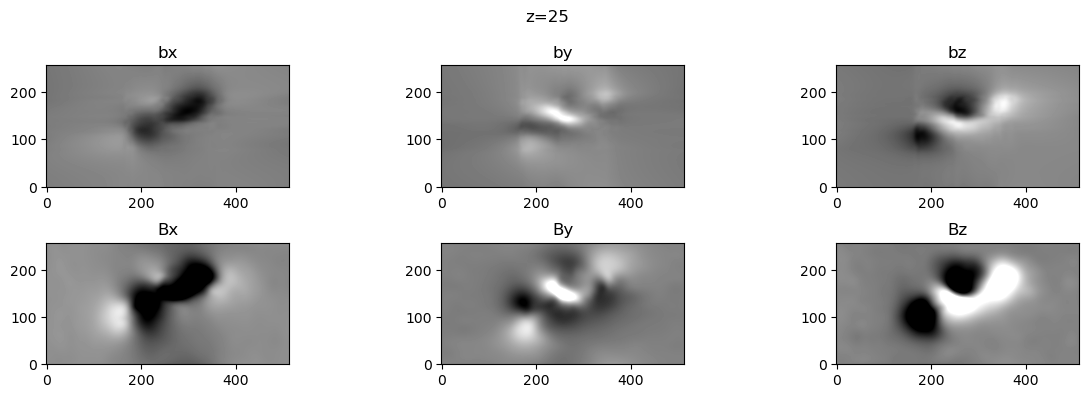

In [ ]:
plot_overview(b, b_true, z=25, b_norm=100)

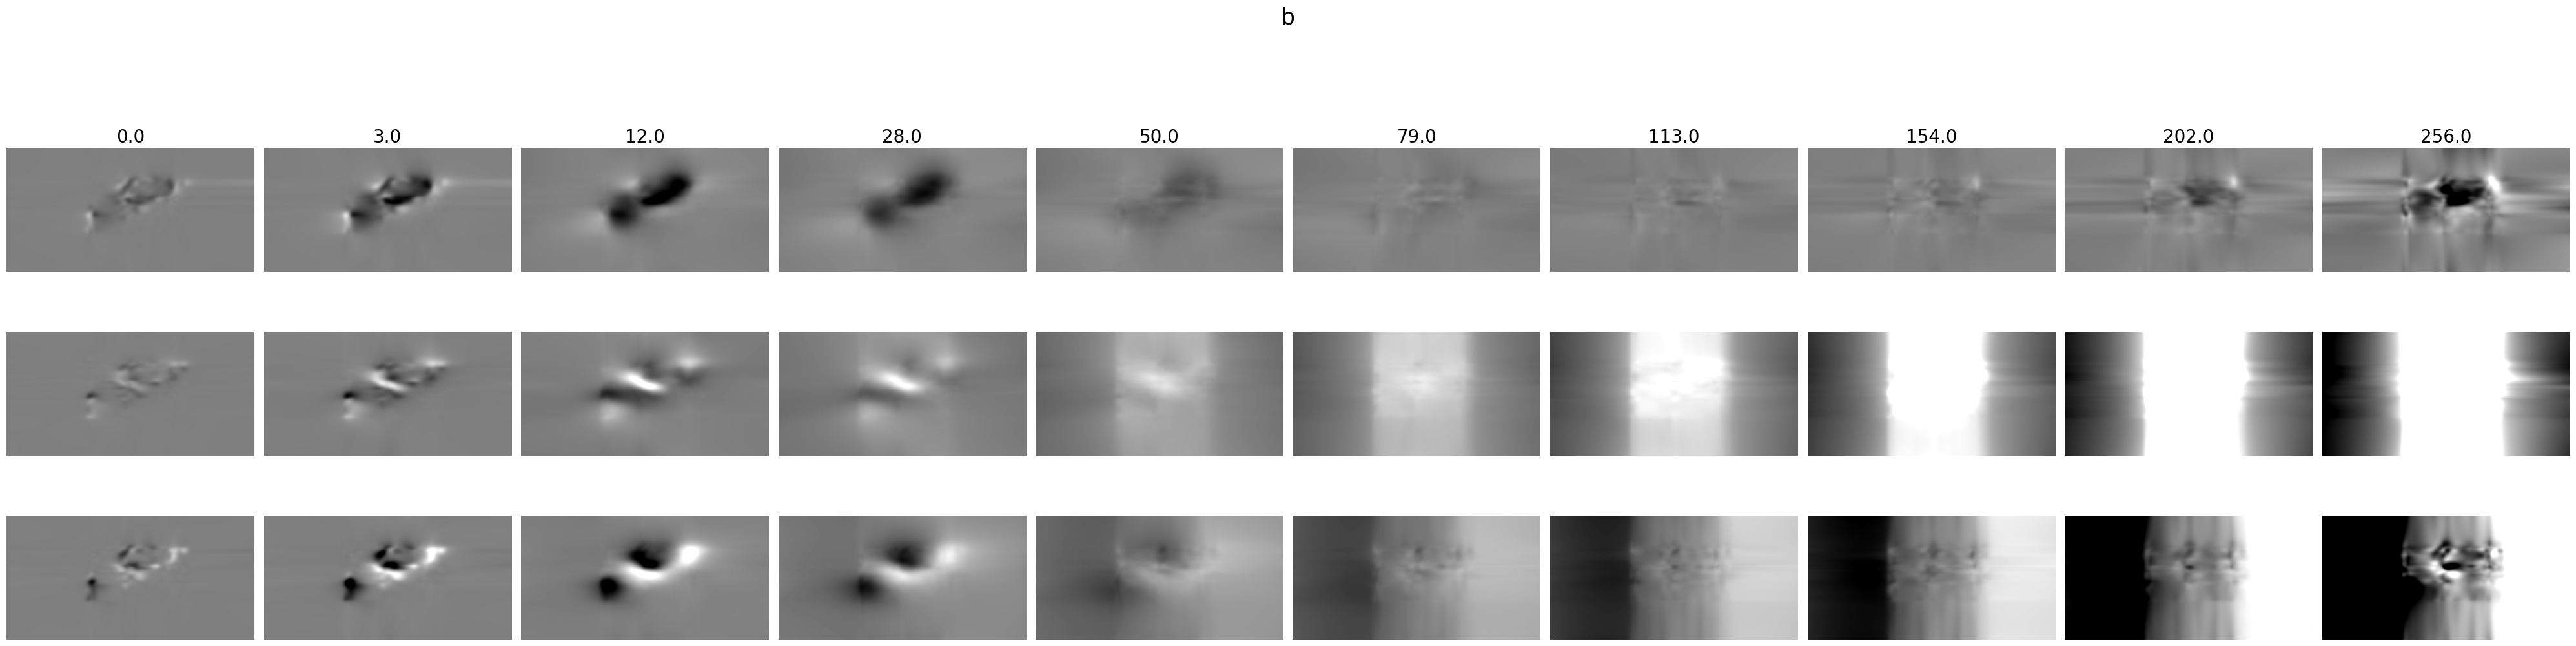

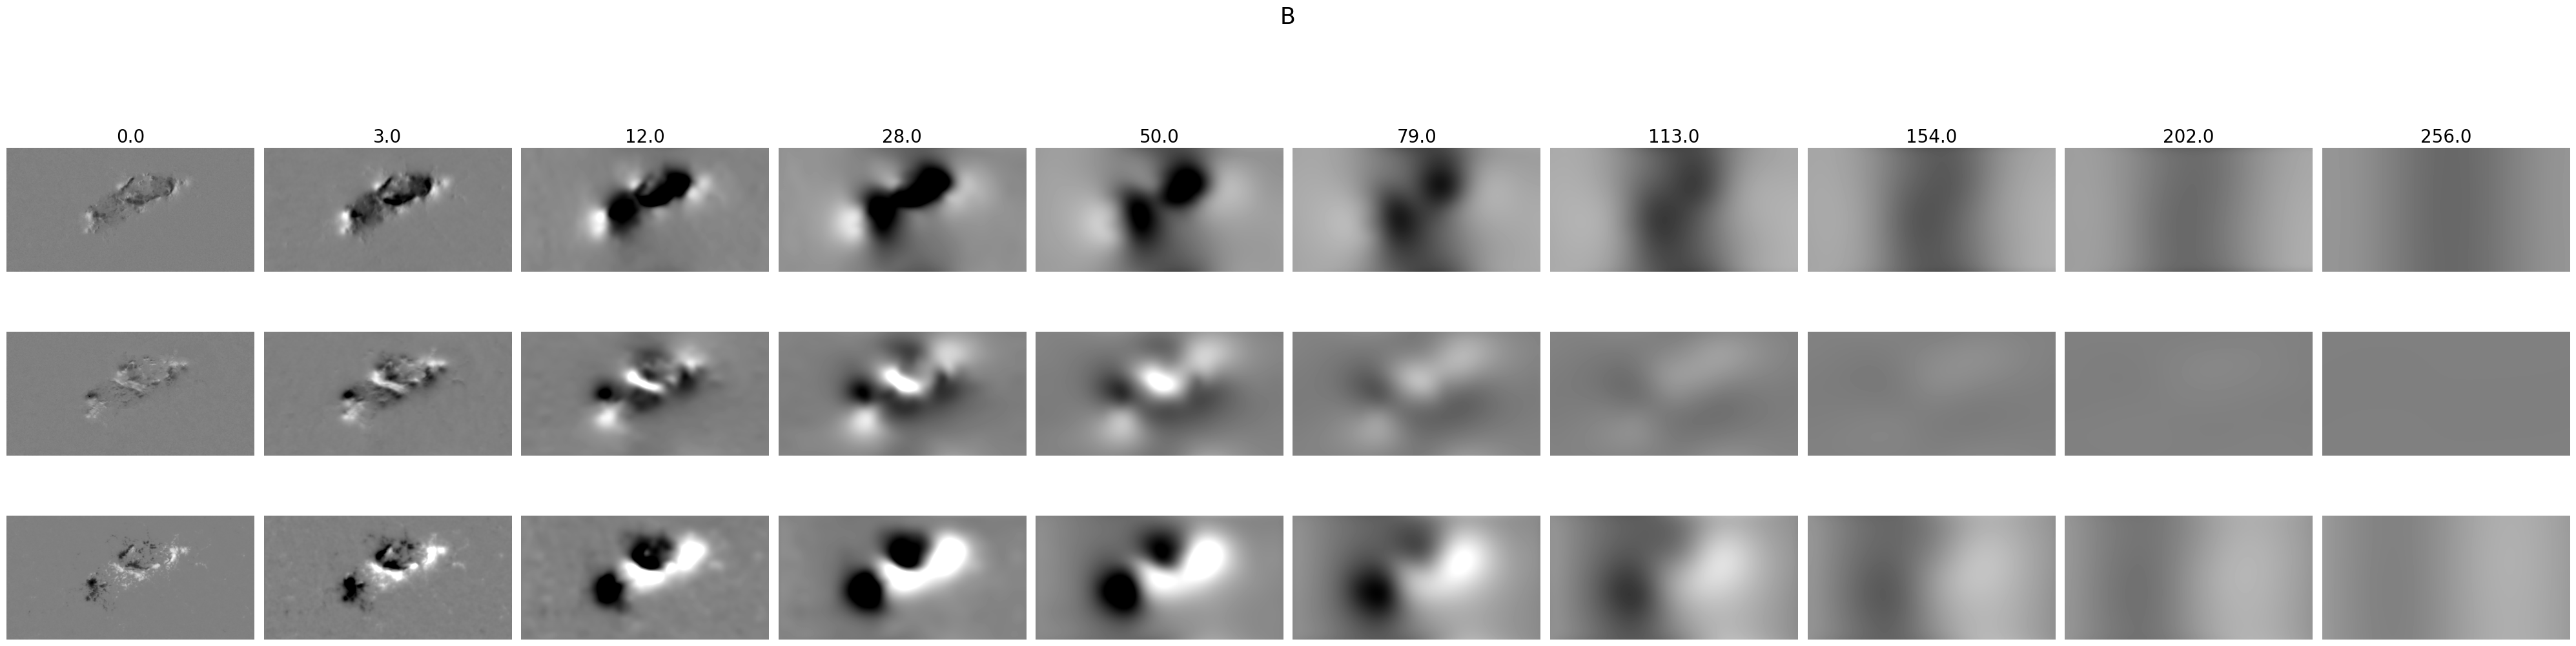

In [ ]:
plot_sample(b, b_true)

sig_J * 1e2: 58.8834; Lf: 2.9861; Ld: 2.3590
DIVERGENCE [1/pix]: 0.0081; THETA [deg] 36.0743
DIVERGENCE [1/pix]: 0.0081; THETA [deg] 36.0743


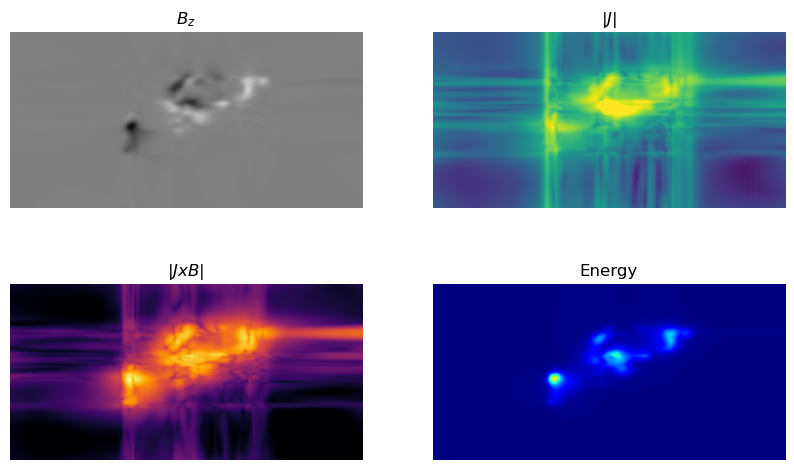

In [ ]:
valid(b)

sig_J * 1e2: 72.0747; Lf: 57.5472; Ld: 10.7184
DIVERGENCE [1/pix]: 129488.1276; THETA [deg] nan
DIVERGENCE [1/pix]: 0.0033; THETA [deg] 46.1162


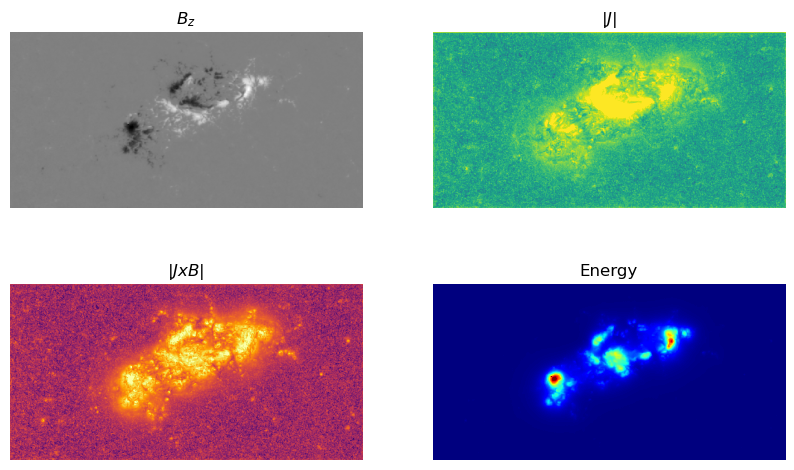

In [ ]:
valid(b_true)

In [ ]:
import pyvista as pv
pv.set_jupyter_backend('static')

In [ ]:
from utils.mag_plotting import create_mesh, mag_plotter

bx = b[..., 0]
by = b[..., 1]
bz = b[..., 2]

mesh = create_mesh(bx, by, bz)

b_plot = mag_plotter(mesh)

vmin = -2500
vmax = 2500
i_siz = 160
j_siz = 100
i_res = 16
j_res = 16

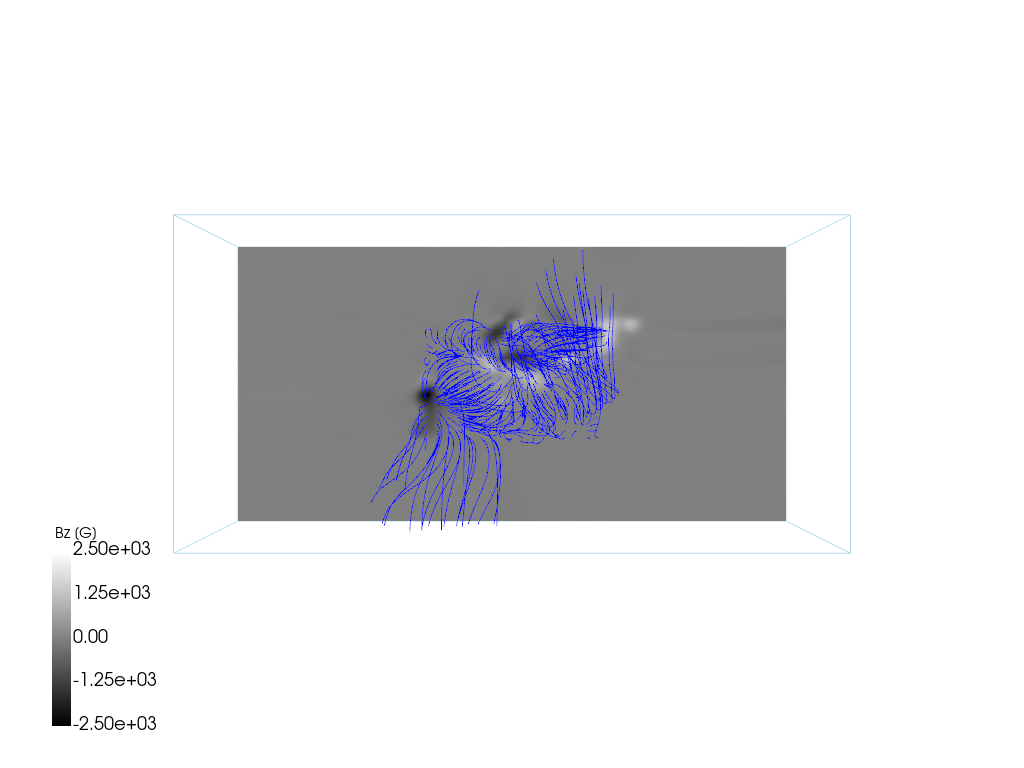

In [ ]:
b_plot.pv_streamline_Bz(camera_position='xy', i_siz=i_siz, j_siz=j_siz, i_resolution=i_res, j_resolution=j_res, vmin=vmin, vmax=vmax);

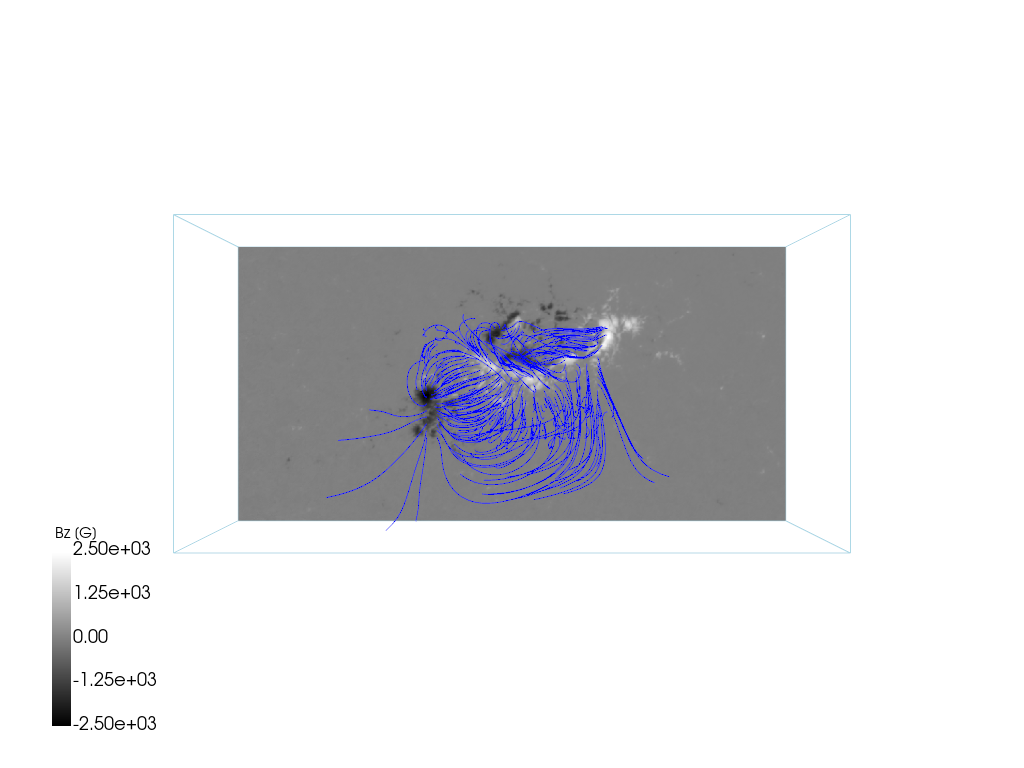

In [ ]:
b_true_x = b_true[..., 0]
b_true_y = b_true[..., 1]
b_true_z = b_true[..., 2]

b_true_mesh = create_mesh(b_true_x, b_true_y, b_true_z)

b_true_plot = mag_plotter(b_true_mesh)

b_true_plot.pv_streamline_Bz(camera_position='xy', i_siz=i_siz, j_siz=j_siz, i_resolution=i_res, j_resolution=j_res, vmin=vmin, vmax=vmax);